# 3. Linear ODEs and Eigenvalue Problems

In [1]:
import numpy as np

from scipy.linalg import solve, eig

import matplotlib.pyplot as plt

In [28]:
def ChebyshevD(N):
    row = np.arange(N + 1)[:, None]
    col = np.arange(N + 1)[None, :]
    x = np.cos(np.pi * row / N)
    c = ((1 + (col % N == 0)) * (-1) ** col).T
    X = np.ones(N + 1) * x
    dX = X - X.T
    D = c @ (1 / c.T) / (dX + np.eye(N + 1))
    D1 = D - np.diag(np.sum(D, axis=1))
    D2 = D1@D1
    return x, D1, D2

## 3.1. Simple Boundary Value Problem

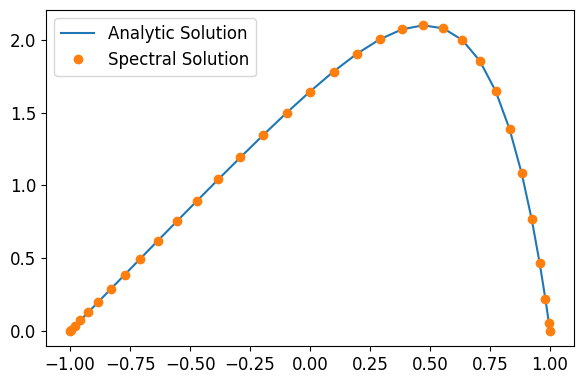

In [55]:
N = 32
x, D1, D2 = ChebyshevD(N)

L_bc = D2[1:-1, 1:-1]
x_bc = x[1:-1, :]
f_bc = - np.exp(4*x_bc)
y_bc = solve(L_bc, f_bc)

y    = np.concatenate([[[0]], y_bc ,[[0]]], axis = 0) 

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(1,1, figsize = (6, 4));
plt.rc('font', size = 12)

ax.plot(x, (np.cosh(4) + np.sinh(4) * x - np.exp(4 * x)) / 16, label = 'Analytic Solution')
ax.plot(x, y, 'o', label = 'Spectral Solution')
ax.legend(loc = 'upper left')

plt.tight_layout()
################################################################################

## 3.2 Eigenvalue Problem with Dirichlet Boundary Conditions

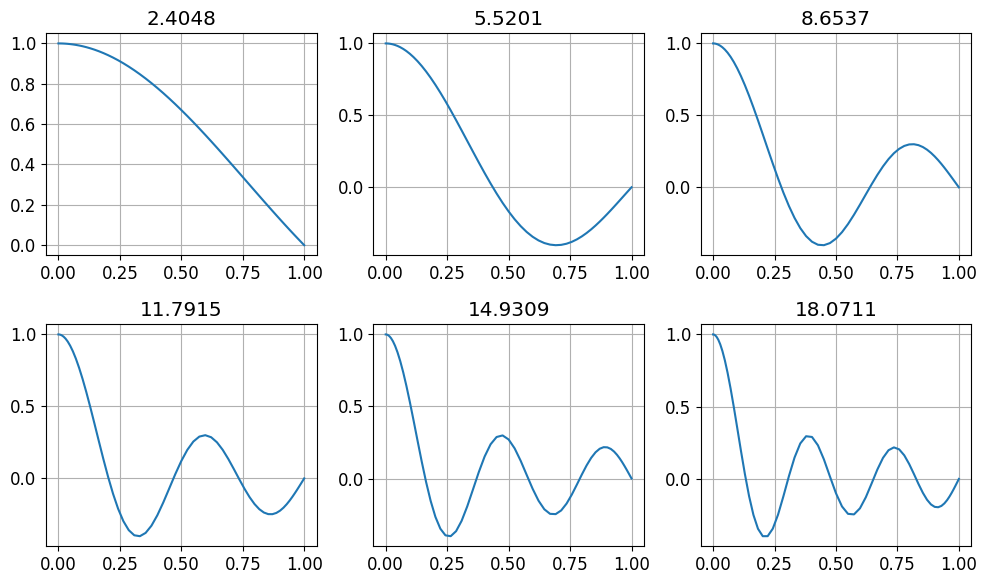

In [152]:
N = 64
x, D1, D2 = ChebyshevD(N)

x  = (1 - x) / 2
xf = x.flatten()
I = np.eye(N+1)
D1 = - 2 * D1
D2 = + 4 * D2 

A =   np.diag(xf) @ D2 + D1
B = - np.diag(xf)

A[-1,:] = I[-1,:]
B[-1,:] = 0

lam2, V = eig(A, B)

# Sort the eigenvalues and normalize
indices = np.argsort(lam2.real)
indices = indices[lam2[indices] > 0]
lam = np.sqrt(lam2.real[indices])
V   = V[:, indices]
V  /= (V[0, :] + (V[0, :]==0))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(2,3, figsize = (10, 6));
plt.rc('font', size = 12)

for i in range(2):
    for j in range(3):
        ax[i, j].plot(x, V[:, 3*i + j])
        ax[i, j].set_title(f'{lam[3*i + j]:.4f}')
        ax[i, j].grid()

plt.tight_layout()
################################################################################

## 3.2 Eigenvalue Problem with Neumann Boundary Conditions

In [ ]:
N = 64
x, D1, D2 = ChebyshevD(N)

x  = (1 - x) / 2
xf = x.flatten()
D1 = - 2 * D1
D2 = + 4 * D2 

A =   np.diag(xf) @ D2 + D1
B = - np.diag(xf)

A[-1,:] = D1[-1,:]
B[-1,:] = 0

lam2, V = eig(A, B)

# Sort the eigenvalues and normalize
indices = np.argsort(lam2.real)
indices = indices[lam2[indices] > 0]
lam = np.sqrt(lam2.real[indices])
V   = V[:, indices]
V  /= (V[0, :] + (V[0, :]==0))

################################################################################
################################ PLOTTING PART #################################
################################################################################
fig, ax = plt.subplots(2,3, figsize = (10, 6));
plt.rc('font', size = 12)

for i in range(2):
    for j in range(3):
        ax[i, j].plot(x, V[:, 3*i + j])
        ax[i, j].set_title(f'{lam[3*i + j]:.4f}')
        ax[i, j].grid()

plt.tight_layout()
################################################################################